### Extract Fabric Monthly Blog Details 
#### Sandeep Pawar | fabric.guru 
#### Blog : https://fabric.guru/unstructured-to-structured-data-extracting-features-from-fabric-monthly-update-blog


In [1]:
%pip install google-generativeai --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow-skinny 2.14.3 requires protobuf<5,>=3.12.0, but you have protobuf 5.29.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from textwrap import dedent


def get_blog(url):
    ## Get blog content as markdown using Jina api
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    
    except requests.RequestException as e:
        print(f"Error: {e}")
        return None

url = "https://r.jina.ai/https://blog.fabric.microsoft.com/en-US/blog/microsoft-fabric-january-2025-update/"
content = dedent(get_blog(url)) #dedent to remove white spaces and reduce #tokens. I could have preprocessed the text more.



In [3]:
instruction = """

Extract the following structured data from the given Microsoft Fabric update blog post:
{
"publicationDate": "The date the blog post was published (YYYY-MM-DD format)",
"updates": [
        {
    "workload": "The main category (e.g. Power BI Desktop, Power BI, Core, OneLake, Data Warehouse, Data Engineering, Data Science, Real-Time Intelligence, Data Factory, Databases)",
    "fabricItem": "The Fabric item type (must be one of: Power BI Desktop, Data pipeline, Dataflow Gen1, Dataflow Gen2, Eventstream, Mirrored Azure Cosmos DB, Mirrored Azure SQL Database, Mirrored Snowflake, Mirrored database, Notebook, Spark Job Definition, Datamart, Eventhouse, Lakehouse, Sample warehouse, Semantic model, Warehouse, Apache Airflow Job, Azure Data Factory, AI Skill, Environment, Experiment, ML model, KQL Queryset, Activator, SQL database, Scorecard, Dashboard, Paginated report, Real-Time Dashboard, Report, API for GraphQL, Fabric User Data Functions)",
    "feature": "The specific new feature or update being described",
    "description": "A brief 1-2 sentence summary of what the feature does or its key benefits, improvements",
    "status": "Is this a new feature being announced, update to an existing feature, or deprecation of a feature. Must be one of : Update, New, Deprecation",
    "tasks": ["List of applicable tasks, must be one or more of: Get data, Store data, Prepare data, Analyze and train data, Track data, Visualize data, Develop data"]
        }
    ]
}
Constraints:

Extract the publication date from the blog post metadata
Use the hierarchical structure to identify workloads, Fabric items, and features
Analyze the description and context to identify the most appropriate Fabric item from the provided list. If enough information is not available, leave it blank.
Summarize descriptions concisely, focusing on key functionality and benefits. 
Analyze the description to assign relevant task tags, using only the provided task options
Return only the extracted JSON data without any explanation

Apply the following extraction patterns:

Use the Keyword Trigger Extractor pattern to identify main workloads, Fabric items, and individual features
Apply the Semantic Extractor pattern to understand and summarize the descriptions, and to infer the appropriate Fabric item when not explicitly mentioned
Utilize the Pattern Matcher to identify availability status, and applicable tasks
Employ the Specify Constraints pattern to ensure adherence to the provided lists for Fabric items and tasks

"""

In [10]:
import google.generativeai as genai
import json
import pandas as pd

def create_and_use_model(api_key, model_name, config, instruction, content):
    """
    Returns Gemini's reponse.

    Parameters:
        api_key (str): The API key for authentication.
        model_name (str): The name of the model.
        config (dict): The configuration settings for the model.
        instruction (str): The instruction for the model.
        content (str): The content to send as a message.

    Returns:
        dict: The result of the model's response.
    """
    genai.configure(api_key=api_key)

    # model
    model = genai.GenerativeModel(
        model_name=model_name,
        generation_config=config,
        system_instruction=instruction,
    )

    chat_session = model.start_chat(
        history=[]
    )

    response = chat_session.send_message(content)
    result = json.loads(response.text)
    
    return result


api_key = "<>"
model_name = "gemini-1.5-flash-002"
config = {
    "temperature": 1,
    "max_output_tokens": 8192,
    "response_mime_type": "application/json",
}

result = create_and_use_model(api_key, model_name, config, instruction, content)
date = result['publicationDate']
df = pd.json_normalize(result["updates"]).assign(publicationDate = date)
df.head()


,workload,fabricItem,feature,description,status,tasks,publicationDate
0,Power BI,Report,Unlock suggested questions from standard promp...,"When using Copilot, a new prompt 'Answer a que...",Update,"[Analyze and train data, Visualize data]",2025-01-30
1,Power BI,Report,Explore this data: new entry point from a visual,A new 'Explore this data' option in the visual...,New,"[Analyze and train data, Visualize data]",2025-01-30
2,Power BI,Report,Storytelling in PowerPoint – New reset behavior,Improved 'Reset' command allows resetting the ...,Update,[Visualize data],2025-01-30
3,Power BI,Report,Storytelling in PowerPoint – Supporting page u...,Page Down/Up keys can now navigate between sli...,Update,[Visualize data],2025-01-30
4,Power BI,Power BI Desktop,Save to OneDrive and SharePoint: updated file ...,Updates to the Power BI file picker simplify n...,Update,"[Get data, Visualize data]",2025-01-30


StatementMeta(, add47422-70be-471b-9cc7-f610db50b514, 56, Finished, Available, Finished)

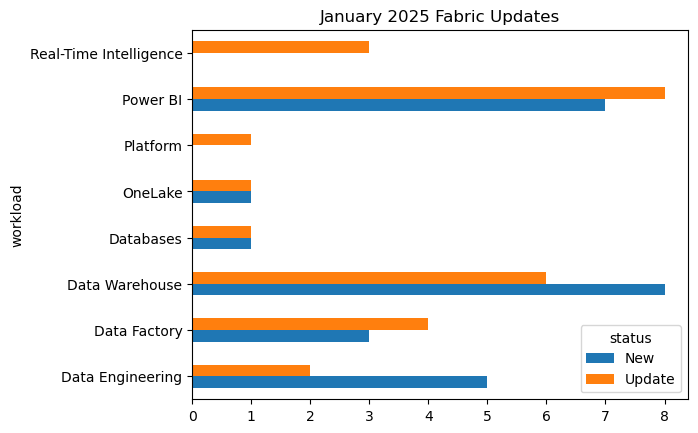

In [44]:
pd.crosstab(df.workload, df.status).plot(kind="barh", title = "January 2025 Fabric Updates");

### Using Fabric OpenAI Deployment

In [27]:
import requests
from textwrap import dedent
import json
import pyspark.sql.functions as F
from synapse.ml.services.openai import OpenAIChatCompletion
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd

def get_blog(url):
    ## Get blog content as markdown using Jina api
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    
    except requests.RequestException as e:
        print(f"Error: {e}")
        return None

url = "https://r.jina.ai/https://blog.fabric.microsoft.com/en-US/blog/microsoft-fabric-january-2025-update/"
content = dedent(get_blog(url)) #dedent to remove white spaces and reduce #tokens. I could have preprocessed the text more.

schema = StructType([
    StructField("fabric_blog", StringType(), True)
])

data = [(content, )]
df = spark.createDataFrame(data, schema)

instructions = """

Extract the following structured data from the given Microsoft Fabric update blog post:
{
"publicationDate": "The date the blog post was published (YYYY-MM-DD format)",
"updates": [
        {
    "workload": "The main category (e.g. Power BI Desktop, Power BI, Core, OneLake, Data Warehouse, Data Engineering, Data Science, Real-Time Intelligence, Data Factory, Databases)",
    "fabricItem": "The Fabric item type (must be one of: Power BI Desktop, Data pipeline, Dataflow Gen1, Dataflow Gen2, Eventstream, Mirrored Azure Cosmos DB, Mirrored Azure SQL Database, Mirrored Snowflake, Mirrored database, Notebook, Spark Job Definition, Datamart, Eventhouse, Lakehouse, Sample warehouse, Semantic model, Warehouse, Apache Airflow Job, Azure Data Factory, AI Skill, Environment, Experiment, ML model, KQL Queryset, Activator, SQL database, Scorecard, Dashboard, Paginated report, Real-Time Dashboard, Report, API for GraphQL, Fabric User Data Functions)",
    "feature": "The specific new feature or update being described",
    "description": "A brief 1-2 sentence summary of what the feature does or its key benefits, improvements",
    "status": "Is this a new feature being announced, update to an existing feature, or deprecation of a feature. Must be one of : Update, New, Deprecation",
    "tasks": ["List of applicable tasks, must be one or more of: Get data, Store data, Prepare data, Analyze and train data, Track data, Visualize data, Develop data"]
        }
    ]
}
Constraints:

Extract the publication date from the blog post metadata
Use the hierarchical structure to identify workloads, Fabric items, and features
Analyze the description and context to identify the most appropriate Fabric item from the provided list. If enough information is not available, leave it blank.
Summarize descriptions concisely, focusing on key functionality and benefits. 
Analyze the description to assign relevant task tags, using only the provided task options
Return only the extracted JSON data without any explanation

Apply the following extraction patterns:

Use the Keyword Trigger Extractor pattern to identify main workloads, Fabric items, and individual features
Apply the Semantic Extractor pattern to understand and summarize the descriptions, and to infer the appropriate Fabric item when not explicitly mentioned
Utilize the Pattern Matcher to identify availability status, and applicable tasks
Employ the Specify Constraints pattern to ensure adherence to the provided lists for Fabric items and tasks

"""

chat_df = (df
  .withColumn("messages",
    F.array(
      F.struct(
        F.lit("system").alias("role"),
        F.lit("system").alias("name"),
        F.lit(instructions).alias("content")),
      F.struct(
        F.lit("user").alias("role"),
        F.lit("user").alias("name"),
        F.col("fabric_blog").alias("content")
      )
    )
  )
)


chat_completion = (
  OpenAIChatCompletion()
    .setDeploymentName("gpt-4-32k")
    .setMessagesCol("messages")
    .setErrorCol("error")
    .setMaxTokens(8192)
    .setTemperature(0.7)
    .setOutputCol("completions")
)

result = chat_completion.transform(chat_df).cache()

json_df =(result.select(F.col("completions.choices").getItem(0).getField("message").getField("content")))

result2 = json_df.toPandas().iloc[0,0]
json_result = json.loads(result2.replace('\n', ''))
final_df = pd.json_normalize(json_result['updates'])
final_df

StatementMeta(, add47422-70be-471b-9cc7-f610db50b514, 39, Finished, Available, Finished)

,workload,fabricItem,feature,description,status,tasks
0,Power BI,Power BI Desktop,Unlock suggested questions from standard promp...,This feature enables users to select from stan...,Update,[Analyze and train data]
1,Power BI,Report,Explore this data: new entry point from a visual,This feature makes data exploration easier by ...,New,"[Analyze and train data, Visualize data]"
2,Power BI,Dashboard,Storytelling in PowerPoint – New reset behavior,This feature enhances the integration of Power...,Update,[Visualize data]
3,Data Engineering,Notebook,Python notebook,"Python Notebook, designed for BI developers an...",New,"[Prepare data, Analyze and train data, Develop..."
4,Data Engineering,Notebook,NotebookUtils session management utilities,A new utility in NotebookUtils has been introd...,New,"[Prepare data, Analyze and train data, Develop..."
5,Data Warehouse,Data pipeline,COPY INTO column count check,A new option for COPY INTO has been introduced...,New,"[Store data, Prepare data]"
6,Data Warehouse,Data pipeline,Enhancing COPY INTO operations with Granular P...,COPY INTO command execution now requires users...,New,[Store data]
7,Data Factory,Dataflow Gen2,Simplify data ingestion with Copy Job: more co...,"Copy Job now supports more connectors, includi...",Update,"[Get data, Store data]"
